<a href="https://colab.research.google.com/github/k-vinamr/rera_construction_pred/blob/main/30_oct_8_floor_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [3]:
data = pd.read_excel('8_floor_data.xlsx')

In [4]:
data.head()


,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,PERCENTAGE,...,8th floor Columns casting,8th Floor slab casting,Brick work of 6th to 8th Floor,"Electrical concealed, PVC Fitting, plastering at 5th-8th floor",Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,other work
0,SHREE SWAMI SAMARTH PROMOTERS AND DEVELOPERS,Residential/Group Housing,2022-09-02,2023-12-31,685.00,141.30,8,MAHARASHTRA,485,0.004771,...,6.016221,10.644084,16.197519,24.064885,27.767176,41.650763,41.650763,25.453244,41.650763,13.883588
1,Orion Developers,Residential/Group Housing,2022-06-20,2025-12-31,419.72,148.80,8,MAHARASHTRA,1290,0.026718,...,16.001908,28.311069,43.082061,64.007634,73.854962,110.782443,110.782443,67.700382,110.782443,36.927481
2,GLOBAL CONSTRUCTIONS,Residential/Group Housing,2021-09-09,2022-03-30,326.95,152.30,8,MAHARASHTRA,202,0.028626,...,2.505725,4.433206,6.746183,10.022901,11.564885,17.347328,17.347328,10.601145,17.347328,5.782443
3,VERSATILEREALTORSPRIVATELIMITED,Residential/Group Housing,2020-05-18,2020-09-30,798.21,152.75,8,MAHARASHTRA,135,0.014313,...,1.674618,2.962786,4.508588,6.698473,7.729008,11.593511,11.593511,7.084924,11.593511,3.864504
4,ARFA REALTIES,Residential/Group Housing,2023-01-24,2024-07-31,851.97,154.70,8,MAHARASHTRA,554,0.017176,...,6.872137,12.158397,18.501908,27.488550,31.717557,47.576336,47.576336,29.074427,47.576336,15.858779


In [5]:
# Converting date columns to datetime objects
data['actual_commencement_date'] = pd.to_datetime(data['actual_commencement_date'], format='%d-%m-%Y', errors='coerce')
data['estimated_finish_date'] = pd.to_datetime(data['estimated_finish_date'], format='%d-%m-%Y', errors='coerce')


In [6]:
current_date = datetime.now()

In [7]:
data['duration_since_commencement'] = (current_date - data['actual_commencement_date']).dt.days
data['remaining_duration'] = (data['estimated_finish_date'] - current_date).dt.days
data['progress_ratio'] = data['duration_since_commencement'] / data['total_days']

In [8]:
# Define a function to determine the project status
def determine_status(row):
    if current_date > row['estimated_finish_date']:
        return 'completed'
    elif current_date >= row['actual_commencement_date']:
        return 'running'
    else:
        return 'upcoming'

# Apply the function to create the 'Status' column
data['current_stage'] = data.apply(determine_status, axis=1)

# Print the DataFrame with the 'Status' column
data


,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,PERCENTAGE,...,Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,other work,duration_since_commencement,remaining_duration,progress_ratio,current_stage
0,SHREE SWAMI SAMARTH PROMOTERS AND DEVELOPERS,Residential/Group Housing,2022-09-02,2023-12-31,685.00,141.30,8,MAHARASHTRA,485,0.004771,...,27.767176,41.650763,41.650763,25.453244,41.650763,13.883588,423,61,0.872165,running
1,Orion Developers,Residential/Group Housing,2022-06-20,2025-12-31,419.72,148.80,8,MAHARASHTRA,1290,0.026718,...,73.854962,110.782443,110.782443,67.700382,110.782443,36.927481,497,792,0.385271,running
2,GLOBAL CONSTRUCTIONS,Residential/Group Housing,2021-09-09,2022-03-30,326.95,152.30,8,MAHARASHTRA,202,0.028626,...,11.564885,17.347328,17.347328,10.601145,17.347328,5.782443,781,-580,3.866337,completed
3,VERSATILEREALTORSPRIVATELIMITED,Residential/Group Housing,2020-05-18,2020-09-30,798.21,152.75,8,MAHARASHTRA,135,0.014313,...,7.729008,11.593511,11.593511,7.084924,11.593511,3.864504,1260,-1126,9.333333,completed
4,ARFA REALTIES,Residential/Group Housing,2023-01-24,2024-07-31,851.97,154.70,8,MAHARASHTRA,554,0.017176,...,31.717557,47.576336,47.576336,29.074427,47.576336,15.858779,279,274,0.503610,running
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,THALIA INVESTMENT PRIVATE LIMITED,Residential/Group Housing,2021-09-09,2023-07-31,26858.28,39545.02,8,MAHARASHTRA,690,NaN,...,39.503817,59.255725,59.255725,36.211832,59.255725,19.751908,781,-92,1.131884,completed
1551,Shekhar Home Developers,Residential/Group Housing,2016-09-16,2020-12-31,63058.80,48162.08,8,Rajasthan,1567,NaN,...,89.713740,134.570611,134.570611,82.237595,134.570611,44.856870,2600,-1034,1.659221,completed
1552,Krishna Kripa Buildconcepts Private Limited,Residential/Group Housing,2017-03-27,2021-03-26,9261.12,57781.00,8,Rajasthan,1460,NaN,...,83.587786,125.381679,125.381679,76.622137,125.381679,41.793893,2408,-949,1.649315,completed
1553,SATARA MUNICIPAL COUNCIL SATARA,Residential/Group Housing,2021-09-29,2025-08-31,46083.19,67276.33,8,MAHARASHTRA,1432,NaN,...,81.984733,122.977099,122.977099,75.152672,122.977099,40.992366,761,670,0.531425,running


In [11]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
data['area_bin'] = pd.cut(data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    data_min = grouped[feature].min()
    data_max = grouped[feature].max()
    data_mean = grouped[feature].mean()
    data_count = grouped[feature].count()
    result = pd.concat([data_min, data_max, data_mean, data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                  Min     Max        Mean  Count
area_bin                                        
(0, 500]        112.0  1290.0  584.944444     36
(500, 1000]     100.0  1918.0  647.220408    245
(1000, 1500]    100.0  3934.0  761.677419    279
(1500, 2000]     96.0  2912.0  857.810345    232
(2000, 2500]    109.0  2094.0  865.302521    119
...               ...     ...         ...    ...
(75000, 75500]    NaN     NaN         NaN      0
(75500, 76000]    NaN     NaN         NaN      0
(76000, 76500]  478.0   478.0  478.000000      1
(76500, 77000]    NaN     NaN         NaN      0
(77000, 77500]  749.0   749.0  749.000000      1

[155 rows x 4 columns]




In [12]:
# Filter the DataFrame based on the condition
filtered_data = data[data['total_built_up_area_saleable_area'] < 30000]

In [14]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(filtered_data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
filtered_data['area_bin'] = pd.cut(filtered_data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = filtered_data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    filtered_data_min = grouped[feature].min()
    filtered_data_max = grouped[feature].max()
    filtered_data_mean = grouped[feature].mean()
    filtered_data_count = grouped[feature].count()
    result = pd.concat([filtered_data_min, filtered_data_max, filtered_data_mean, filtered_data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         112.0  1290.0   584.944444     36
(500, 1000]      100.0  1918.0   647.220408    245
(1000, 1500]     100.0  3934.0   761.677419    279
(1500, 2000]      96.0  2912.0   857.810345    232
(2000, 2500]     109.0  2094.0   865.302521    119
(2500, 3000]     108.0  2669.0  1026.381356    118
(3000, 3500]      98.0  2527.0   903.123711     97
(3500, 4000]     112.0  2517.0  1035.536232     69
(4000, 4500]     114.0  2334.0   946.197183     71
(4500, 5000]     112.0  3604.0   951.276596     47
(5000, 5500]     113.0  3251.0  1115.684211     38
(5500, 6000]     112.0  2700.0  1260.240000     25
(6000, 6500]     122.0  2626.0  1005.840000     25
(6500, 7000]     113.0  1795.0   930.384615     13
(7000, 7500]     317.0  1697.0  1002.000000     13
(7500, 8000]     227.0  2304.0  1172.625000      8
(8000, 8500]     419.0  2207.0  1123.545455     11
(8

<ipython-input-14-3ac3ef85beec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['area_bin'] = pd.cut(filtered_data['total_built_up_area_saleable_area'], bin_edges)


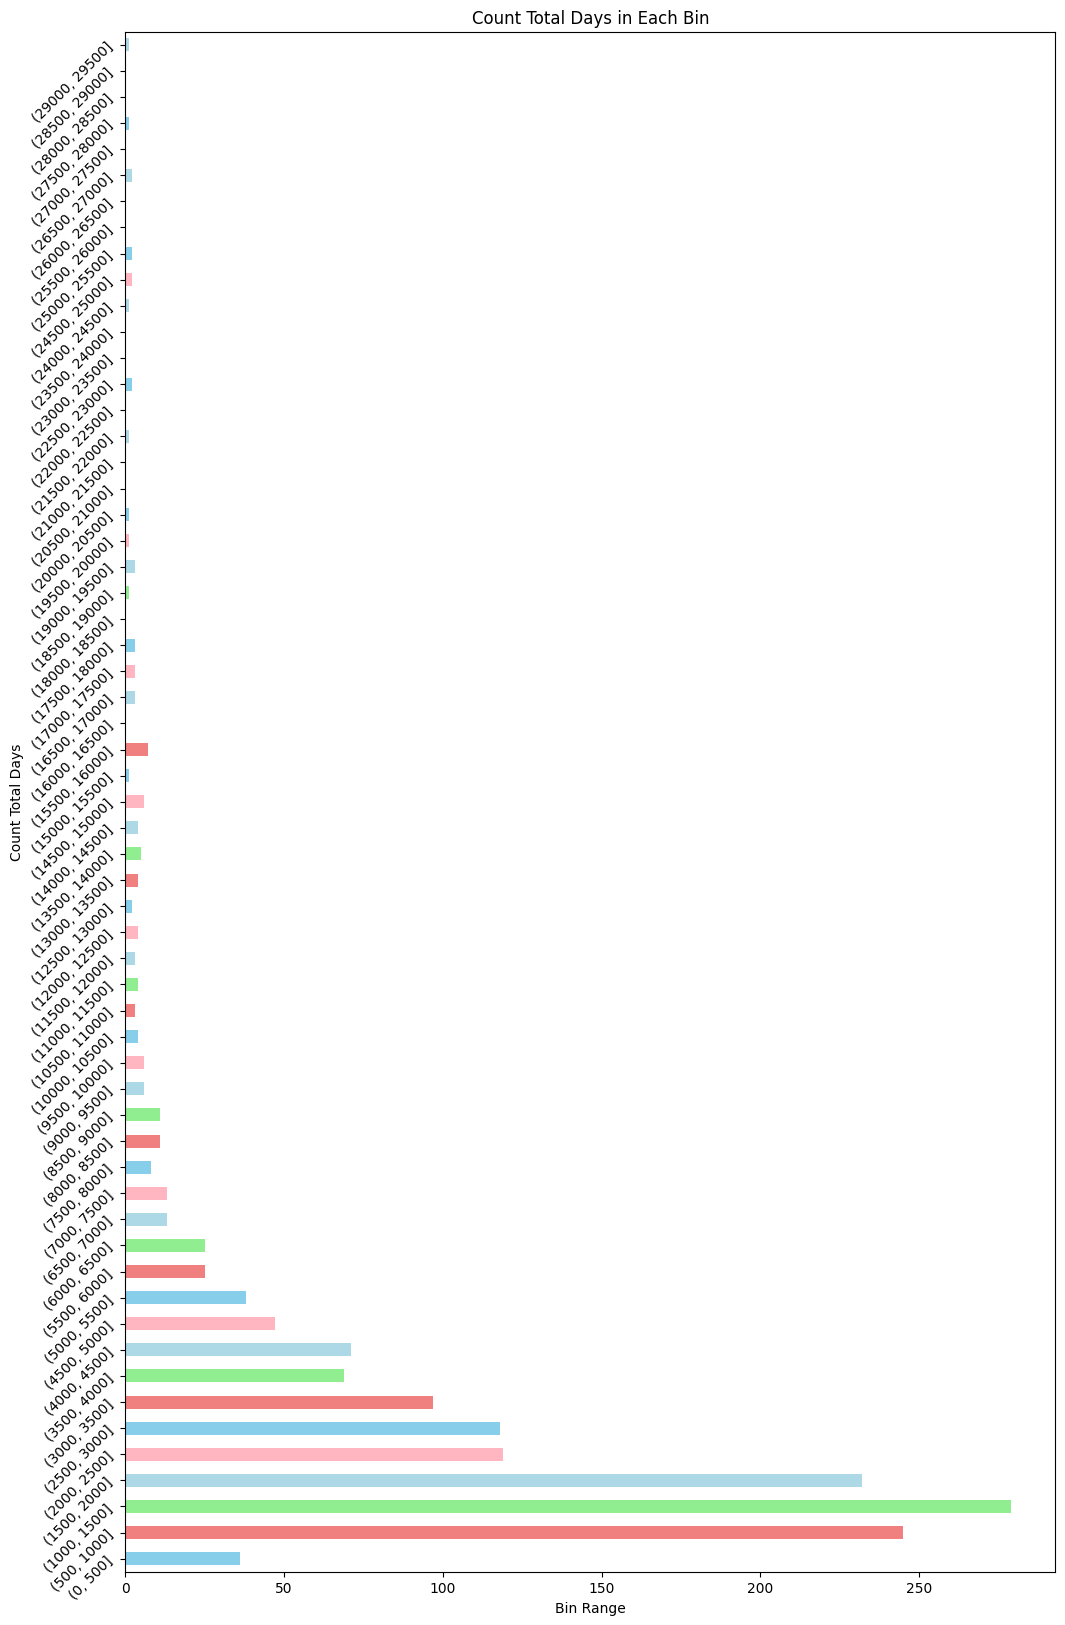

In [16]:
# Create a bar chart for the mean values
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightpink']
plt.figure(figsize=(12, 20))
filtered_data_count.plot(kind='barh', color=colors)
plt.xlabel('Bin Range')
plt.ylabel('Count Total Days')
plt.title('Count Total Days in Each Bin')
plt.yticks(range(len(filtered_data_count)), filtered_data_count.index, rotation=45)
plt.show()


In [17]:
import pandas as pd
import random
from datetime import timedelta

# Assuming you have your filtered data in a DataFrame named filtered_df
# Ensure you have loaded the necessary libraries and data

# Define the number of data points you want to generate
desired_data_points = 20000  # Change this number as needed

# Create an empty DataFrame to store the augmented data
augmented_data = pd.DataFrame(columns=filtered_data.columns)

# Copy the original data to the augmented DataFrame
augmented_data = augmented_data.append(filtered_data, ignore_index=True)

# Define the range for small changes (you can adjust this)
date_change_range = 7  # Number of days for date changes
area_change_range = 10  # Range for changing area

# Generate additional data points
while len(augmented_data) < desired_data_points:
    # Randomly select an existing row to modify
    index_to_modify = random.randint(0, len(filtered_data) - 1)
    row_to_modify = augmented_data.iloc[index_to_modify].copy()

    # Make small changes to the selected row
    row_to_modify['actual_commencement_date'] += timedelta(days=random.randint(-date_change_range, date_change_range))
    row_to_modify['estimated_finish_date'] += timedelta(days=random.randint(-date_change_range, date_change_range))
    row_to_modify['total_built_up_area_saleable_area'] += random.uniform(-area_change_range, area_change_range)
    row_to_modify['total_area_of_project'] += random.uniform(-area_change_range, area_change_range)

    # Add the modified row to the augmented DataFrame
    augmented_data = augmented_data.append(row_to_modify, ignore_index=True)

    # You may want to truncate the DataFrame to the desired number of data points
    augmented_data = augmented_data[:desired_data_points]

    # Now, augmented_data contains the augmented data with the specified changes

Streaming output truncated to the last 5000 lines.
<ipython-input-17-433956e125ad>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-17-433956e125ad>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-17-433956e125ad>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-17-433956e125ad>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_

In [18]:
# Define the bin edges
bin_width = 500
max_value = int(augmented_data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
augmented_data['area_bin'] = pd.cut(augmented_data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = augmented_data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    augmented_data_min = grouped[feature].min()
    augmented_data_max = grouped[feature].max()
    augmented_data_mean = grouped[feature].mean()
    augmented_data_count = grouped[feature].count()
    result = pd.concat([augmented_data_min, augmented_data_max, augmented_data_mean, augmented_data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         112.0  1290.0   590.576271    472
(500, 1000]      100.0  1918.0   657.494570   3223
(1000, 1500]     100.0  3934.0   759.941225   3641
(1500, 2000]      96.0  2912.0   847.391678   2908
(2000, 2500]     109.0  2693.0   863.587476   1549
(2500, 3000]     108.0  2669.0  1013.751161   1507
(3000, 3500]      98.0  2527.0   889.692188   1280
(3500, 4000]     112.0  2517.0  1037.589520    916
(4000, 4500]     114.0  2334.0   956.781120    964
(4500, 5000]     112.0  3604.0   930.307301    589
(5000, 5500]     113.0  3251.0  1124.023301    515
(5500, 6000]     112.0  2973.0  1237.905844    308
(6000, 6500]     122.0  2626.0  1051.045016    311
(6500, 7000]     113.0  1795.0   879.512048    166
(7000, 7500]     317.0  2304.0  1018.196319    163
(7500, 8000]     227.0  2304.0  1200.250000     84
(8000, 8500]     419.0  2207.0  1082.452830    159
(8

In [19]:
augmented_data.to_csv('augmented_8_floor.csv', index=False)